In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [117]:
def calc_rhs(A_fin, N, k, t, H, h, W=0.025):
    eta = calc_eta(calc_m(k, t, h), H)
    return 1 / (h*(calc_A_base(t, N, L, W) + N * eta * A_fin))
    
def calc_m(k, t, h):
    return np.sqrt(2*h / (k*t))

def calc_eta(m, H):
    return np.tanh(m*H)/(m*H)

def determine_N(spacing, t, W=0.025):
    return int(W/(spacing+t))

def calc_A_base(t, N, L, W):
    return L*(W-N*t)

# material properties
k_al = 210
k_cu = 400

# air velocity properties
v = np.arange(0, 20, 0.1)
h = 10.45 - v + 10*np.sqrt(v)

# figure properties
single_fig = (10, 6)
double_fig = (16, 6)

# air properties at STP
roe = 1.1614 # kg/m^3
c_p = 1.007 # kJ/(kg K)
meu = 184e-7 # (N s)/m^2
neu = 15.89e-6 # m^2/s
k_air = 26.3e-3 #W/(m K)
alpha_air = 22.5e-6 # m^2 /s
Pr = 0.707

In [4]:
# Edit here
t = 0.0002 # fin thickness
N = 8 # number of fins
H = 0.05 # fin height
L = 0.045 # heat sink length
W = 0.025 # heat sink width
k = k_al # for aluminum
# k = k_cu # for copper

## Evaluating the Limits of Air Cooled Thermal Systems
Ognyan Moore

We can build a $16\frac{W}{cm^2}$ air cooled product; find out how I know

## Overview

Thermal Systems can be modeled like electrical circuits, where each component that the heat has to travel through is modeled like a resistor as such:

$$ Q = \frac{T_{JC} - T_{AMB}}{R_{TH}} $$

$Q$ is the thermal power we need to dissipate

$T_{JC}$ is the juction temperature of our devices

$R_{TH}$ is the thermal resistance of our cooling syste

In order to accomodate large values of $Q$, we need low values for $R_{TH}$ such that our $T_{JC}$ does not exceed rated values.

### More precisely, the thermal circuit looks like this:
<div style="float: center">
![Equivalent Circuit](images/Equivalient_thermal_circuit_2.png)
</div>
$Q$ is the thermal power that needs to be dissipated

$T_J$ is the junction temperature of the device

$T_C$ is the temperature at the case of the device

$T_H$ is the temperature where the heat-sink as attached

$T_{AMB}$ is the ambient temperature 

From the data done at Mentor Graphs on the FJ100, we actually have a really good idea of what $R_{\theta JC} + R_{\theta CH}$  should be.  Since we use similar (or in some cases identical SLMs and LEDs) from product to product, these values are good to use for other types of analysis.

![T3ster Data](images/T3ster_data.png)


$$R_{\theta JC} + R_{\theta CH} = 0.18\frac{K}{W}$$

<div style="float: center">
![Equivalent Circuit](images/Equivalient_thermal_circuit_2.png)
</div>
We now know what $T_J$ cannot exceed ($125^\circ C$), we know what $R_{\theta JC} + R_{\theta CH}$ is, and we know what $T_{AMB}$ is.

Using optical modeling from Doug, in addition to quantum efficiency measurements we take in-house, we can estimate what $Q$ (heat generated) will be in relation to a target $\frac{W}{cm^2}$ irradiance.

So how do we calculate the thermal resistance of a heat sink $(R_{\theta HA}$ ) to see if we have a product that will be feasible?

It's complicated, but not that complicated...

Heat that is dissipated through heat sinks needs to propogate through the base, and then conduct partially through the fins before being convected away to the ambient air.  Here is where the math starts getting messy....

**$$R_{\theta HA} = \frac{1}{h (A_{base} + N_{fin} \ \eta_{fin} \ A_{fin})} + \frac{B}{kWL}$$**

<div style="float: right">
![some easter-egg text](images/model-heat-sink.png)
</div>


$B$ is the thickness of the base

$k$ is the thermal conductivity of the material

$W$ is the width of the heat sink

$L$ is the length of the heat sink

$h$ is the convection coefficient (we will actually be solving for this value in the end)

$A_{base}$ is the area of the base that is exposed to air-flow

$N_{fin}$ is the number of fins

$\eta_{fin}$ is the fin efficiency (more on this later)

$A_{fin}$ is the surface area of each fin


The resistance of the base of the heatsink can be calculated as

**$$R_{base} = \frac{B}{kWL}$$**

While we can see that minimizing B or maximizing k would have a major benefit, the major component of the heat sink thermal resistance isn't from the base, but from the fins.

**$$R_{HS} = \frac{1}{h (A_{base} + N_{fin} \ \eta_{fin} \ A_{fin})}$$**

Let's look at the parameters that make up the thermal resistance formula and see what typical values are like





First let's look at $h$

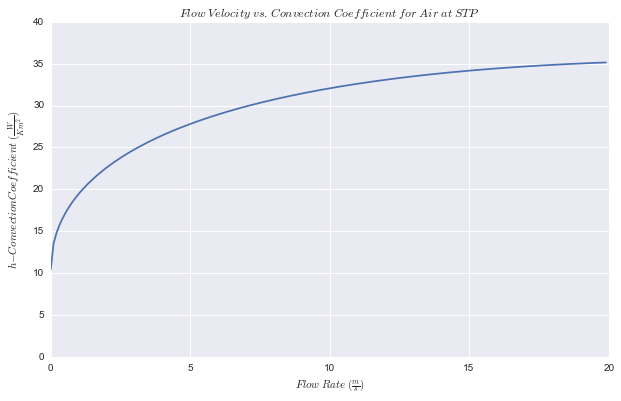

In [5]:
fig, ax = plt.subplots(figsize=single_fig)
ax.plot(v, h)
ax.set_title('$Flow \ Velocity \ vs. \ Convection \ Coefficient \ for \ Air \ at \ STP$')
ax.set_xlabel(r'$Flow \ Rate \ (\frac{m}{s})$')
ax.set_ylabel(r'$h - Convection Coefficient \ (\frac{W}{K m^2})$')
ax.set_ylim(bottom=0)
plt.show()

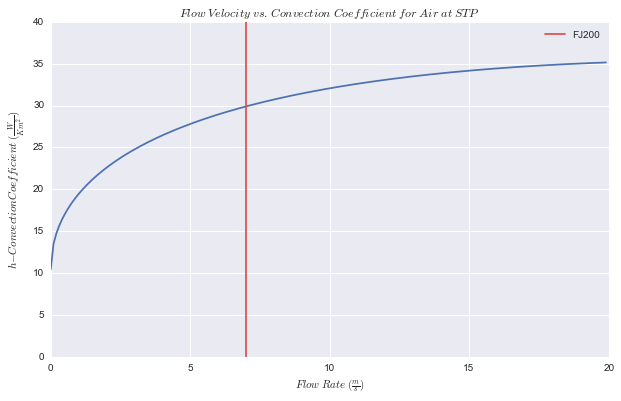

In [6]:
fig, ax = plt.subplots(figsize=single_fig)
ax.plot(v, h)
ax.set_title('$Flow \ Velocity \ vs. \ Convection \ Coefficient \ for \ Air \ at \ STP$')
ax.set_xlabel(r'$Flow \ Rate \ (\frac{m}{s})$')
ax.set_ylabel(r'$h - Convection Coefficient \ (\frac{W}{K m^2})$')
ax.set_ylim(bottom=0)
ax.axvline(x=7, color=sns.xkcd_rgb["pale red"], label='FJ200')
plt.legend(loc='best')
plt.show()

$h$ varies from a value of $10.5\frac{W}{m^2K}$ and can get up to $35\frac{W}{m^2K}$

$$R_{HS} = \frac{1}{h (A_{base} + N_{fin} \ \eta_{fin} \ A_{fin})}$$

Next We Look at **$\eta_{fin}$** otherwise known as fin efficiency

$$\eta_{fin} = \frac{tanh(m H_{fin})}{m H_{fin}}$$


$H_{fin}$ is the height of the fin

$$ m = \sqrt{ \frac{2h}{k_{fin}t_{fin}}}$$

$k_{fin}$ is the thermal conductivity of the fin material

$t_{fin}$ is the thickness of the fin

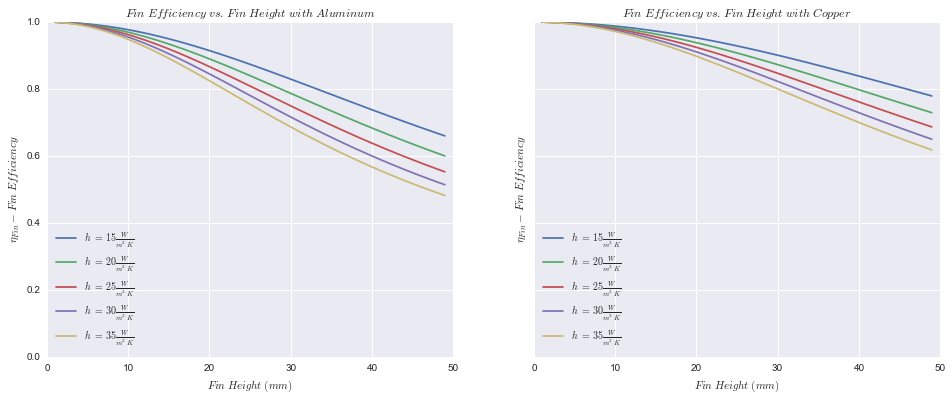

In [290]:
H = np.arange(0, 0.05, 0.001)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=double_fig, sharey=True, dpi=400)
ax1.plot(H*1000, calc_eta(calc_m(k_al, t, 15), H), label=r'$h \ = \ 15 \frac{W}{m^2K}$')
ax1.plot(H*1000, calc_eta(calc_m(k_al, t, 20), H), label=r'$h \ = \ 20 \frac{W}{m^2K}$')
ax1.plot(H*1000, calc_eta(calc_m(k_al, t, 25), H), label=r'$h \ = \ 25 \frac{W}{m^2K}$')
ax1.plot(H*1000, calc_eta(calc_m(k_al, t, 30), H), label=r'$h \ = \ 30 \frac{W}{m^2K}$')
ax1.plot(H*1000, calc_eta(calc_m(k_al, t, 35), H), label=r'$h \ = \ 35 \frac{W}{m^2K}$')
ax1.set_xlabel(r'$Fin \ Height \ (mm)$')
ax1.set_ylabel(r'$\eta_{Fin} \ - \ Fin \ Efficiency$')
ax1.set_ylim(bottom=0)
ax1.set_title(r'$Fin \ Efficiency \ vs. \ Fin \ Height \ with \ Aluminum$')
ax1.legend(loc='best')


ax2.plot(H*1000, calc_eta(calc_m(k_cu, t, 15), H), label=r'$h \ = \ 15 \frac{W}{m^2K}$')
ax2.plot(H*1000, calc_eta(calc_m(k_cu, t, 20), H), label=r'$h \ = \ 20 \frac{W}{m^2K}$')
ax2.plot(H*1000, calc_eta(calc_m(k_cu, t, 25), H), label=r'$h \ = \ 25 \frac{W}{m^2K}$')
ax2.plot(H*1000, calc_eta(calc_m(k_cu, t, 30), H), label=r'$h \ = \ 30 \frac{W}{m^2K}$')
ax2.plot(H*1000, calc_eta(calc_m(k_cu, t, 35), H), label=r'$h \ = \ 35 \frac{W}{m^2K}$')
ax2.set_xlabel(r'$Fin \ Height \ (mm)$')
ax2.set_ylabel(r'$\eta_{Fin} \ - \ Fin \ Efficiency$')
ax2.set_ylim(bottom=0)
ax2.set_title(r'$Fin \ Efficiency \ vs. \ Fin \ Height \ with \ Copper$')
ax2.legend(loc='best')

plt.show()

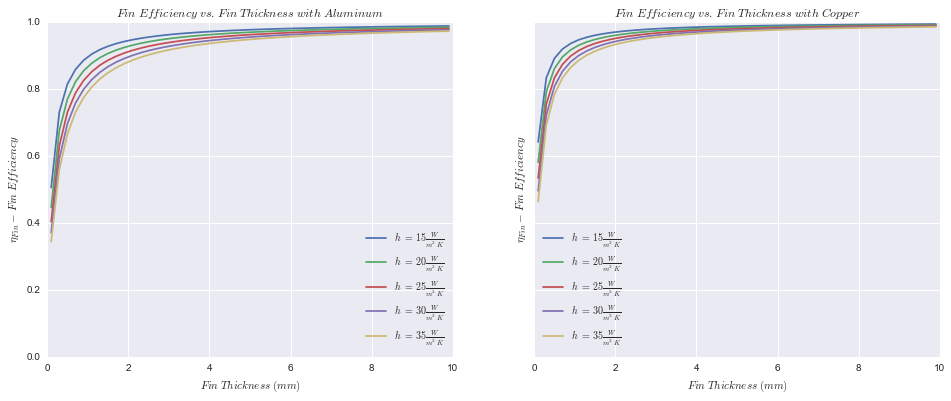

In [284]:
thickness = np.arange(0.0001, 0.010, 0.0002)
H = 0.05

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=double_fig, sharey=True, dpi=400)
ax1.plot(thickness*1000, calc_eta(calc_m(k_al, thickness, 15), H), label=r'$h \ = \ 15 \frac{W}{m^2K}$')
ax1.plot(thickness*1000, calc_eta(calc_m(k_al, thickness, 20), H), label=r'$h \ = \ 20 \frac{W}{m^2K}$')
ax1.plot(thickness*1000, calc_eta(calc_m(k_al, thickness, 25), H), label=r'$h \ = \ 25 \frac{W}{m^2K}$')
ax1.plot(thickness*1000, calc_eta(calc_m(k_al, thickness, 30), H), label=r'$h \ = \ 30 \frac{W}{m^2K}$')
ax1.plot(thickness*1000, calc_eta(calc_m(k_al, thickness, 35), H), label=r'$h \ = \ 35 \frac{W}{m^2K}$')
ax1.set_xlabel(r'$Fin \ Thickness \ (mm)$')
ax1.set_ylabel(r'$\eta_{Fin} \ - \ Fin \ Efficiency$')
ax1.set_ylim(bottom=0)
ax1.set_title(r'$Fin \ Efficiency \ vs. \ Fin \ Thickness \ with \ Aluminum$')
ax1.legend(loc='best')
ax1.plot()

ax2.plot(thickness*1000, calc_eta(calc_m(k_cu, thickness, 15), H), label=r'$h \ = \ 15 \frac{W}{m^2K}$')
ax2.plot(thickness*1000, calc_eta(calc_m(k_cu, thickness, 20), H), label=r'$h \ = \ 20 \frac{W}{m^2K}$')
ax2.plot(thickness*1000, calc_eta(calc_m(k_cu, thickness, 25), H), label=r'$h \ = \ 25 \frac{W}{m^2K}$')
ax2.plot(thickness*1000, calc_eta(calc_m(k_cu, thickness, 30), H), label=r'$h \ = \ 30 \frac{W}{m^2K}$')
ax2.plot(thickness*1000, calc_eta(calc_m(k_cu, thickness, 35), H), label=r'$h \ = \ 35 \frac{W}{m^2K}$')
ax2.set_xlabel(r'$Fin \ Thickness \ (mm)$')
ax2.set_ylabel(r'$\eta_{Fin} \ - \ Fin \ Efficiency$')
ax2.set_ylim(bottom=0)
ax2.set_title(r'$Fin \ Efficiency \ vs. \ Fin \ Thickness \ with \ Copper$')
ax2.legend(loc='best')
ax2.plot()
plt.show()

Efficiency values can range from 0.5 to 1.0 for Aluminum, or from 0.6 to 1 for Copper

But **efficiency** isn't what we are after...

We want to **minimize** $R_{TH}$

$$R_{TH} = \frac{1}{h (A_{base} + N_{fin} \ \eta_{fin} \ A_{fin})} + \frac{B}{kWL} + 0.18 \frac{K}{W}$$

From looking at the formula, we need to strike the right balance bewtween $N_{fin}$ and $\eta_{fin}$ while maximizing $A_{fin}$.  

So we just up $N_{fin}$ as high as possible, right?

Well...

We can only space the fins so close together...

Why can't we place a near infinate number of fins right up against one-another?  Boundary layers!

Boundary layer thickness for laminar flow (which is what we have) is defined with the following formula:

$$\delta \approx \frac{5L}{\sqrt{Re}}$$

$L$ is the Flow Length

$Re$ is the reynolds number (non-dimensional number characterizing the fluid flow)

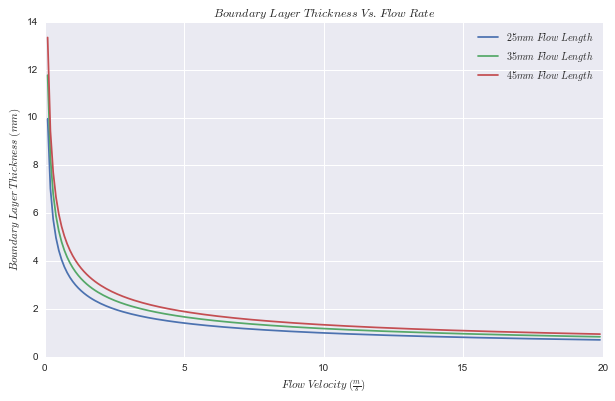

In [7]:
#############
# Discussion of Boundary Layers Here
#############

delta = 5 * W / np.sqrt((roe*v*W) / meu)
fig, ax1 = plt.subplots(figsize=single_fig)
ax1.plot(v, (5 * 0.025 / np.sqrt((roe*v*.025) / meu))*1000, label=r"$25mm \ Flow \ Length$")
ax1.plot(v, (5 * 0.035 / np.sqrt((roe*v*.035) / meu))*1000, label=r"$35mm \ Flow \ Length$")
ax1.plot(v, (5 * 0.045 / np.sqrt((roe*v*.045) / meu))*1000, label=r"$45mm \ Flow \ Length$")
ax1.set_title(r'$Boundary \ Layer \ Thickness \ Vs. \ Flow \ Rate$')
ax1.set_xlabel(r'$Flow \ Velocity \ (\frac{m}{s})$')
ax1.set_ylabel(r'$Boundary \ Layer \ Thickness \ (mm)$')
ax1.legend(loc='best')
plt.show()

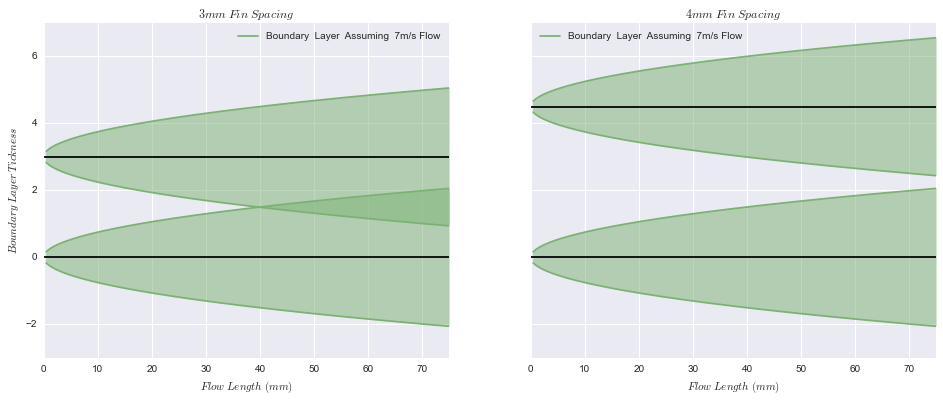

In [181]:
x = np.arange(0, .0755, 0.0005)
V = 7
delta = 5 * x / np.sqrt((roe*V*x)/meu) * 1000
color=sns.xkcd_rgb["faded green"]
alpha=0.5

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=double_fig, sharey=True)
fin_spacing = 3
ax1.fill_between(x*1000, 0, delta, color=color, alpha=alpha)
ax1.plot(x*1000, delta, color=color, label='Boundary  Layer  Assuming  {}m/s Flow'.format(V))
ax1.set_ylabel(r'$Boundary \ Layer \ Tickness$')
ax1.fill_between(x*1000, 0, -delta, color=color, alpha=alpha)
ax1.plot(x*1000, -delta, color=color)
ax1.axhline(y=0, color='k')

ax1.fill_between(x*1000, fin_spacing, delta+fin_spacing, color=color, alpha=alpha)
ax1.plot(x*1000, -delta+fin_spacing, color=color)
ax1.fill_between(x*1000, fin_spacing, -delta+fin_spacing, color=color, alpha=alpha)
ax1.plot(x*1000, delta+fin_spacing, color=color)
ax1.axhline(y=fin_spacing, color='k')
ax1.set_title(r'$3mm \ Fin \ Spacing$')
ax1.set_xlabel(r'$Flow \ Length \ (mm)$')
ax1.set_xlim(right=75)
ax1.legend(loc='best')

fin_spacing = 4.5
ax2.plot(x*1000, -delta, color=color)
ax2.plot(x*1000, delta, color=color)
ax2.fill_between(x*1000, 0, delta, color=color, alpha=0.5)
# ax2.set_ylabel(r'$Boundary \ Layer \ Tickness$')
ax2.fill_between(x*1000, 0, -delta, color=color, alpha=0.5)
ax2.axhline(y=0, color='k')

ax2.plot(x*1000, -delta+fin_spacing, color=color, label='Boundary  Layer  Assuming  {}m/s Flow'.format(V))
ax2.plot(x*1000, delta+fin_spacing, color=color)
ax2.fill_between(x*1000, fin_spacing, delta+fin_spacing, color=color, alpha=alpha)
ax2.fill_between(x*1000, fin_spacing, -delta+fin_spacing, color=color, alpha=alpha)
ax2.axhline(y=fin_spacing, color='k')
ax2.set_title(r'$4mm \ Fin \ Spacing$')
ax2.set_xlabel(r'$Flow \ Length \ (mm)$')
ax2.set_xlim(right=75)
ax2.legend(loc='best')
plt.show()

So, can we build a $16\frac{W}{cm^2}$ air cooled product in the FP601 form factor?

First, let's solve for $Q$, the heat generated.

According to Doug's model, the FP501 that produces $20\frac{W}{cm^2}$ on a 6x10 SLM requires that each LED produces 1.0W of light.

We only need $\frac{4}{5}$ of that power, so we can assume needing 0.8W of light per LED, which for 60 LEDs ammounts to 48W of light.

But we lose ~10% to the glass, so we need 53W of light.

Our highest petegry LEDs are approximately 30% efficient at that range, which means to generate 53W of light, we need to have 177W of input power, resulting in **124W of heat**.

Revising the thermal resistance formula:

$$R_{TH} = \frac{1}{h (A_{base} + N_{fin} \ \eta_{fin} \ A_{fin})} + \frac{B}{kWL} + 0.18 \frac{K}{W}$$

Since we are evaluating feasibility, let's see if it can be done with Copper (if it can't be done with Copper, it can't be done with Aluminum)

I will assume a heatsink base of 8mm, a width of 25mm (SLM width), a flow length of 50mm.

For Copper
$$\frac{B}{kWL} = \frac{0.008m}{400\frac{W}{mK}*0.025m*0.050m} = 0.016\frac{K}{W}$$

For Aluminum:
$$\frac{B}{kWL} = \frac{0.008m}{210\frac{W}{mK}*0.025m*0.050m} = 0.016\frac{K}{W}$$

Thermal Resistance of a heat sink: 
$$R_{HS} = \frac{1}{h(A_{base}+N_{fin}\eta_{fin}A_{fin}})$$

In [175]:
def calc_rhs(A_fin, N, k, t, H, h, W=0.025):
    eta = calc_eta(calc_m(k, t, h), H)
    return 1 / (h*(calc_A_base(t, N, L, W) + N * eta * A_fin))
    
def calc_m(k, t, h):
    return np.sqrt(2*h / (k*t))

def calc_eta(m, H):
    return np.tanh(m*H)/(m*H)

def determine_N(spacing, t, W=0.025):
    return np.around(W/(spacing+t), decimals=2)

def calc_A_base(t, N, L, W):
    return L*(W-N*t)

In [189]:
slms = 1
t = np.arange(0.4, 2.02, 0.02)/1000
spacing = 4.5 / 1000
H = 135 / 1000
W = 25*slms / 1000
L = 75 / 1000
h = 35
A_fin = 2*H*L
r_hs = np.zeros([t.shape[0]])
for index, thickness in enumerate(t):
    N = determine_N(spacing, thickness, W-spacing*0.5)
    r_hs[index] = calc_rhs(A_fin, N, k_cu, thickness, H, h, W)
#     print('{0:1.4f} Thermal Resistance for {2}fins of thickness of {1:2.4f}'.format(r_hs[index], thickness*1000, N))
print('{0:1.3f} is the best R_hs value calculated {2} fins with thickness of {1:2.1f}mm'.format(np.min(r_hs), 
                                                                                                t[np.argmin(r_hs)]*1000, 
                                                                                               determine_N(spacing, t[np.argmin(r_hs)], W-spacing*0.5)))

target_irr = 12
led_efficiency = .24
N_leds = 66
Q_led=.751*1.1
Q_slm_light = Q_led*N_leds
Q_slm_light *= target_irr/16
Q_slm = Q_slm_light / led_efficiency
Q_slm_heat = Q_slm - Q_slm_light
Q = Q_slm_heat*slms
R_total = 0.016+0.15+np.min(r_hs)
delta_T = R_total * Q
print('Junction temperature will be {0:1.1f}deg C above ambient'.format(delta_T))

0.580 is the best R_hs value calculated 3.57 fins with thickness of 1.9mm
Junction temperature will be 96.6deg C above ambient


In [170]:
W

0.75

References: 

http://www.electronics-cooling.com/2003/02/estimating-parallel-plate-fin-heat-sink-thermal-resistance/

https://en.wikipedia.org/wiki/Thermal_resistance

http://www.engineeringtoolbox.com/convective-heat-transfer-d_430.html